In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np
from Bio import Align
from Bio.Seq import Seq
from Bio.Align import substitution_matrices
import sys
import os
import seaborn as sns
import math


In [2]:
# #Reads the first N lines of the R1 fastq NGS file. Each line of the file is added to a list (cat_R1_reads).
# #Uncomment to load only N lines of fastq file (N/4 reads)
# N=40000
# with open("Categories1-3_R1_001.fastq") as myfile:
#     cat_R1_reads = [next(myfile) for x in range(N)]
    
#__________________________________________________
#Reads the entire fastq NGS file 
#Uncomment to load all the lines of the file
cat_R1_file = open("Categories1-3_R1_001.fastq", "r")
cat_R1_reads = cat_R1_file.readlines()
cat_R1_file.close()
#__________________________________________________

cat_R1_trim = cat_R1_reads[1::4] #Isolates only every fourth line from the fastQ file, i.e. just the reads. The remaining lines of the file are removed.
cat_R1_trim = [i.strip('\n') for i in cat_R1_trim] #this just removes the '\n' from the end of every line


#Repeats the same process as above, for the the R2 NGS file

# #Uncomment to load only N lines of fastq file (N/4 reads)
# with open("Categories1-3_R2_001.fastq") as myfile:
#     cat_R2_reads = [next(myfile) for x in range(N)]

#__________________________________________________    
#Uncomment to load all the lines of the file
cat_R2_file = open("Categories1-3_R2_001.fastq", "r")
cat_R2_reads = cat_R2_file.readlines()
cat_R2_file.close()
#__________________________________________________

cat_R2_trim = cat_R2_reads[1::4]
cat_R2_trim = [i.strip('\n') for i in cat_R2_trim]

cat_data = pd.DataFrame({'Read 1':cat_R1_trim, 'Read 2':cat_R2_trim})
cat_data.to_csv('1_cat_data_raw.csv')
cat_data

,Read 1,Read 2
0,TGCTTACTTATCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAATCCCG...
1,ACGCCGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...
2,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CAATGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...
3,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...
4,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...
...,...,...
384681,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...
384682,ACGCCGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...
384683,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCGATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...
384684,ACGCCGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...


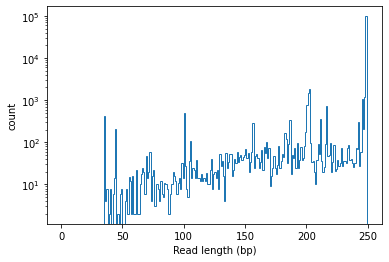

In [3]:
#Plots a histogram of the read lengths in both R1 and R2
readlengths = [len(i) for i in cat_data['Read 1']]+[len(i) for i in cat_data['Read 2']]
read_length_distribution=plt.hist(readlengths, bins = list(range(1, max(readlengths))), histtype='step')
plt.xlabel('Read length (bp)')
plt.ylabel('count')
plt.yscale('log')

In [4]:
# Here I want to parse the indices associated with each read. While I know what the indices should be, 
# I need to be able to account for, at the very least, one or two errors in the index. There are many ways of doing
# this, and the more robust the system is for accomodating errors, the more complicated it is. Kathryn uses regexes,
# but I don't know anything about those. It may be worthwhile to learn more about regexes, but for now I think I'm
# going to go with one of the simplist ways of matching strings with possible mismatches: the Hamming distance. The
# Hamming distance only works with two strings of equal length. It's the number of changes you have to make to one string
# so that it will match the other. E.g. 'bat' and 'cat' have a Hamming distance of 1. 'loot' and 'book' have a Hamming
# distance of 2.

#Define a Hamming distance function
def ham(str1, str2):
    if len(str1) != len(str2):
        print('Error, string lengths must be equal!')
        return
    else:
        i = 0
        count = 0

        while(i < len(str1)):
            if(str1[i] != str2[i]):
                count += 1
            i += 1
        return count
fwd_indices = ['ATACC', 'TTCTT', 'TCTGT']
rev_indices = ['CAATG', 'CTGTG', 'ACGCC']
all_indices = fwd_indices + rev_indices

#Determine the minimum Hamming distance between any two indices
index_hams = []
for i in all_indices:
    for j in all_indices:
        index_hams += [ham(i,j)]

#Unfortunately, the minimum Hamming distance is 2, which means that conceiveably a single mismatch could 
#make it impossible to determine what the correct index is based on index sequence alone. E.g. an index of
#'TTCGT' is equally likely to be forward index 2 or 3. So some sequences may not be usable, but hopefully
#not too many

# This block attempts to determine the index of each read. For each read, it determines the hamming distance between the
# first 5 nucleotides of the read and each possible index. If any of the Hamming distances is 0, it adds a number
# associated with that index ('ATACC' and 'CAATG' = 1, 'TTCTT' and 'CTGTG' = 2, etc) to a list of indices for the reads
# in that fastq file, and adds the direction associated with that read to a list of directions for the reads. If none
# of the hamming distances is 0, but exactly one of the Hamming distances is equal to 1, then it assumes that the
# correct index is the one with a hamming distance of 1 from the read, and similarly adds an associated index number
# and read direction to the respective lists. If none of the hamming distances are <= 1, then it does not try to assign
# and index number or direction to that read. I could potentially refine this so that fewer reads are left unassigned 
# but given that >90% of the reads can be categorized, and our coverage is really good, it's not worth it to figure
#out how to optimize this right now

R1_index=[]
R1_direction = []
for i in cat_data['Read 1']:
    index_hams=[ham(i[0:5], j) for j in all_indices]
    if min(index_hams) == 0:
        index_pos = index_hams.index(0)
        if index_pos == 0:
            R1_index += [1]
            R1_direction += ['Forward']
        elif index_pos == 1:
            R1_index += [2]
            R1_direction += ['Forward']
        elif index_pos == 2:
            R1_index += [3]
            R1_direction += ['Forward']
        elif index_pos == 3:
            R1_index += [1]
            R1_direction += ['Reverse']
        elif index_pos == 4:
            R1_index += [2]
            R1_direction += ['Reverse']
        elif index_pos == 5:
            R1_index += [3]
            R1_direction += ['Reverse']
    elif min(index_hams) == 1:
        if index_hams.count(1) == 1:
            index_pos = index_hams.index(1)
            if index_pos == 0:
                R1_index += [1]
                R1_direction += ['Forward']
            elif index_pos == 1:
                R1_index += [2]
                R1_direction += ['Forward']
            elif index_pos == 2:
                R1_index += [3]
                R1_direction += ['Forward']
            elif index_pos == 3:
                R1_index += [1]
                R1_direction += ['Reverse']
            elif index_pos == 4:
                R1_index += [2]
                R1_direction += ['Reverse']
            elif index_pos == 5:
                R1_index += [3]
                R1_direction += ['Reverse']
        else:
            R1_index += [np.nan]
            R1_direction += [np.nan]
    else:
        R1_index += [np.nan]
        R1_direction += [np.nan]

R2_index=[]
R2_direction = []
for i in cat_data['Read 2']:
    index_hams=[ham(i[0:5], j) for j in all_indices]
    if min(index_hams) == 0:
        index_pos = index_hams.index(0)
        if index_pos == 0:
            R2_index += [1]
            R2_direction += ['Forward']
        elif index_pos == 1:
            R2_index += [2]
            R2_direction += ['Forward']
        elif index_pos == 2:
            R2_index += [3]
            R2_direction += ['Forward']
        elif index_pos == 3:
            R2_index += [1]
            R2_direction += ['Reverse']
        elif index_pos == 4:
            R2_index += [2]
            R2_direction += ['Reverse']
        elif index_pos == 5:
            R2_index += [3]
            R2_direction += ['Reverse']
    elif min(index_hams) == 1:
        if index_hams.count(1) == 1:
            index_pos = index_hams.index(1)
            if index_pos == 0:
                R2_index += [1]
                R2_direction += ['Forward']
            elif index_pos == 1:
                R2_index += [2]
                R2_direction += ['Forward']
            elif index_pos == 2:
                R2_index += [3]
                R2_direction += ['Forward']
            elif index_pos == 3:
                R2_index += [1]
                R2_direction += ['Reverse']
            elif index_pos == 4:
                R2_index += [2]
                R2_direction += ['Reverse']
            elif index_pos == 5:
                R2_index += [3]
                R2_direction += ['Reverse']
        else:
            R2_index += [np.nan]
            R2_direction += [np.nan]
    else:
        R2_index += [np.nan]
        R2_direction += [np.nan]

cat_data['Read 1 Index']=R1_index
cat_data['Read 2 Index']=R2_index
cat_data['Read 1 Direction']=R1_direction
cat_data['Read 2 Direction']=R2_direction

#Create category column in the dataframe. Indices were designed such that the category is just the average of the 
#forward and reverse index numbers
cat_data['Category']=(cat_data['Read 1 Index'] + cat_data['Read 2 Index'])/2
cat_data
cat_data.to_csv('2_cat_data_ind_dir_cat.csv')

In [5]:
#Here I want to clean up my results a little.

#Remove all reads where category could not be determine because one or more of the indices could
#not be parsed.
num = [1,1.5,2,2.5,3]
no_cat = cat_data[~(cat_data['Category'].isin(num))]
cat_data_1= cat_data[(cat_data['Category'].isin(num))].copy()

#Remove all reads where both reads are same direction (there should be one read in each direction)
two_reads = cat_data_1[(cat_data_1['Read 1 Direction'] == cat_data_1['Read 2 Direction'])]
cat_data_2 = cat_data_1[~(cat_data_1['Read 1 Direction'] == cat_data_1['Read 2 Direction'])].copy()
print(str(len(no_cat)+len(two_reads))+ ' reads ('+str((len(no_cat)+len(two_reads))/len(cat_data)*100)+ '%) could not be categorized')
print(str(len(cat_data_2))+ ' reads were categorized')
cat_data_2.to_csv('3_cat_data_ind_dir_cat_QC.csv')
cat_data_2.head(15)

36510 reads (9.490857478566934%) could not be categorized
348176 reads were categorized


,Read 1,Read 2,Read 1 Index,Read 2 Index,Read 1 Direction,Read 2 Direction,Category
0,TGCTTACTTATCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAATCCCG...,2.0,2.0,Forward,Reverse,2.0
1,ACGCCGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,3.0,2.0,Reverse,Forward,2.5
2,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CAATGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1.0,1.0,Forward,Reverse,1.0
3,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,2.0,1.0,Reverse,Forward,1.5
4,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,2.0,2.0,Reverse,Forward,2.0
5,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,2.0,1.0,Reverse,Forward,1.5
6,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1.0,2.0,Forward,Reverse,1.5
7,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,2.0,1.0,Reverse,Forward,1.5
8,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,2.0,2.0,Reverse,Forward,2.0
10,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,2.0,1.0,Reverse,Forward,1.5


Text(0, 0.5, 'Count')

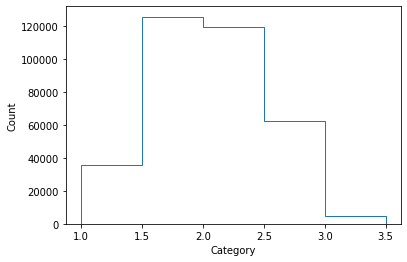

In [6]:
#Create a histogram of the distribution of the categories in the reads
category_distribution=plt.hist(cat_data_2['Category'], bins = [1,1.5,2,2.5,3, 3.5], histtype='step')
plt.xlabel('Category')
plt.ylabel('Count')

In [7]:
###Make two columns containing all forward sequences in one column and all reverse sequences in the other###
cat_data_2['Forward_read'] = pd.Series(dtype=str)
cat_data_2['Reverse_read'] = pd.Series(dtype=str)

###untangle using for loops (accurate, but slow af. update, it's fast af)###

#create empty list for forward and reverse reads
forward = []
reverse = []

#design for loop to parse through each row and determine which read (1 or 2) is the forward sequence, feed into list
for i in cat_data_2.index:
    if cat_data['Read 1 Direction'][i] == 'Forward':
        fr = cat_data_2['Read 1'][i]
    else:
        fr = cat_data_2['Read 2'][i]
    forward.append(fr)

#design for loop to parse through each row and determine which read (1 or 2) is the reverse sequence, feed into list
for i in cat_data_2.index:
    if cat_data_2['Read 1 Direction'][i] == 'Reverse':
        rr = cat_data_2['Read 1'][i]
    else:
        rr = cat_data_2['Read 2'][i]
    reverse.append(rr)


#insert lists of forward and reverse reads into series of each.
cat_data_2['Forward_read'] = forward
cat_data_2['Reverse_read'] = reverse
cat_data_3= cat_data_2[['Read 1 Index','Read 2 Index','Read 1 Direction','Read 2 Direction','Category','Forward_read','Reverse_read']].copy()
cat_data_3.to_csv('4_cat_data_fwd_rev.csv')
cat_data_3.head(15)

,Read 1 Index,Read 2 Index,Read 1 Direction,Read 2 Direction,Category,Forward_read,Reverse_read
0,2.0,2.0,Forward,Reverse,2.0,TGCTTACTTATCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAATCCCG...
1,3.0,2.0,Reverse,Forward,2.5,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,ACGCCGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...
2,1.0,1.0,Forward,Reverse,1.0,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CAATGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...
3,2.0,1.0,Reverse,Forward,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...
4,2.0,2.0,Reverse,Forward,2.0,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...
5,2.0,1.0,Reverse,Forward,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...
6,1.0,2.0,Forward,Reverse,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...
7,2.0,1.0,Reverse,Forward,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...
8,2.0,2.0,Reverse,Forward,2.0,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...
10,2.0,1.0,Reverse,Forward,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...


In [8]:
#Here we define some sequences we want to align to

#ribo_rev is the reverse complement of the intron. We want the rev comp because we will be using the reverse reads to
#align. We also want all the text to be in the same case (reduces complications with text handling algorithms), so
#we'll change it all to uppercase
ribo_rev='CGAGTACTCCAAAACTAATCAATATACTTTCGCATACAAATTAGTTCCCAGCGGCTCCAGTGTTGCATCACTTCATCCGCTAGCTCCCATTAAGGAGAGGTCCGACTATATCTTATGAGAAGAATACATCTTCCCCGACCGACATTTAGTCTGTGAACTGCATCCATATCAACAGAAGATCTGTTGACTTAGGACTTGGCTGCGTGGTTAGGACCATGTCCGTCAGCTTATTACCATACCCTTTGCAAGGCCATCTCAAAGTTTCCCCTGAGACTTGGTACTGAACGGCTGTTGACCCCTTTCCCGCAATTTGACGGTCTTGCCTTTTAAACCGATGCAATCTATTGGTTTAAAGACTAGCTACCAGGTGCATGCCTGATAACTTTTtgaccCAAAGGTAAATATTGCTATTTaggtcagagtagtgacaagt'
ribo_rev=ribo_rev.upper()

#The next sequence we want is the portion of the inserted sequence that is (or should be) present in every reverse
#read, i.e. the sequence from the reverse primer (minus the index) to the start of the intron. Since the great 
#majority of this sequence consists of the interaction sequence, this sequence will be called 'interact'
interact = 'gcttcaataatattgaaaaaggaagagtAAAAAAAAGCCCGCCTTTCGGCGGGCTTTGgtcacctcctagctgactcaaatcaatgcgtgtttcataaagaccagtgatggattgatggataagagtggcatctaaaacttcttttgtagacgtatatcgtttacgatcaattgttgtatcaaaatatttAAAAGCAGCGGGAGCTCCAAGATTCGTCAACGGCAGCA'
interact = interact.upper()


In [9]:
#Here we set up the paramters of the alignment alogithm. I'm not going to claim to fully understand how the 
#alignment function from biopython works, but I do have some familiarity with one of the alignment algorithms it uses
# (the smith-waterman alignment). The biopython manual states that it uses the same algorithm as the ebi water local 
# alignment algorithm (https://www.ebi.ac.uk/Tools/psa/emboss_water/). I did my best to set the scoring for the 
# alignment algorithm used here to be the same as used in by ebi (so you can check your work using their aligner tool
# online). I've gotten it so that they should give the same alighnment, but for some reason the alignment *score* 
# given by this aligner isn't identical to the ebi score.
aligner = Align.PairwiseAligner()
aligner.mode = 'local'
matrix = substitution_matrices.load("Nuc.4.4")
aligner.substitution_matrix = matrix
aligner.open_gap_score = -10
aligner.extend_gap_score = -0.5

In [10]:
###
#So what I intend to do in order to determine where an intron was split at a given read is to:
# 1. Align the reverse read to the inserted sequence in the intron (the variable saved here as 'interact')
# 2. Determine where that alignment ends
# 3. The rest of the read that doesn't get aligned (~17 nucleotides) should correspond to some part of the intron. 
# 4. I will take the unaligned part of the read and align it with the intron. The junction between the inserted 
#    sequence and the intron lies where that portion of the read begins.
###

     GCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCGCCTTTCGGCGGGCTTTGGTCACCTCCTAGCTGACTCAAATCAATGCGTGTTTCATAAAGACCAGTGATGGATTGATGGATAAGAGTGGCATCTAAAACTTCTTTTGTAGACGTATATCGTTTACGATCAATTGTTGTATCAAAATATTTAAAAGCAGCGGGAGCTCCAAGATTCGTCAACGGCAGCA
     ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||.||||||||||||||||||||||||||||||||||||||||.|||||.|||||||||||||||||||.||||||.||.||||.||.|||||||.||||||||||||||||||.||||||||.|||||||||.||||||||||||||.||||||||||||||.||
CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCGCCTTTCGGCGGGCTTTGGTCACCGCCTAGCTGACTCAAATCAATGCGTGTTTCATAAAGACCAGGGATGGTTTGATGGATAAGAGTGGCAACTAAAAATTATTTTTTATACGTATAACGTTTACGATCAATTGTTTTATCAAAAAATTTAAAAGAAGCGGGAGCTCCAATATTCGTCAACGGCACCACCTGTCCATTGGTAATG

     GCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCGCCTTTCGGCGGGCTTTGGTCACCTCCTAGCTGACTCAAATCAATGCGTGTTTCATAAAGACCAGTGATGGATTGATGGATAAGAGTGGCATCTAAAACTTCTTTTGTAGACGTATATCGTTTACGATCAATTGTTGTATCAAAATATTTAAAAGCAGCGGGAGCTCCAAGATTCGTCAACGGCAGCA
     |||||||||||||||||||||||||.||||||||..|||||

,Read 1 Index,Read 2 Index,Read 1 Direction,Read 2 Direction,Category,Forward_read,Reverse_read,Reverse Read inserted sequence alignment score
0,2.0,2.0,Forward,Reverse,2.0,TGCTTACTTATCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAATCCCG...,1095.0
1,3.0,2.0,Reverse,Forward,2.5,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,ACGCCGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1104.0
2,1.0,1.0,Forward,Reverse,1.0,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CAATGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0
3,2.0,1.0,Reverse,Forward,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0
4,2.0,2.0,Reverse,Forward,2.0,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0
...,...,...,...,...,...,...,...,...
384681,2.0,1.0,Reverse,Forward,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0
384682,3.0,2.0,Reverse,Forward,2.5,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,ACGCCGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0
384683,1.0,2.0,Forward,Reverse,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCGATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1131.0
384684,3.0,2.0,Reverse,Forward,2.5,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,ACGCCGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0


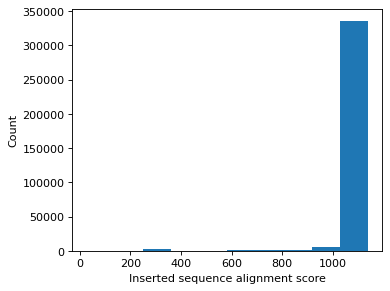

In [11]:
# First, I want to get an idea of what a typical score is for aligning a reverse read to the inserted sequence. This
# cell aligns each reverse read to the inserted sequence and produces a histogram of the resulting scores. It will
# also print out alignments with scores above and/or below a certain threshold score. This is useful if you want to 
# get an idea of what an alignment with a given score actually looks like.

#Note that this cell takes a few (~3) minutes to run
scores=[]
count = 0
for i in cat_data_3.iloc[:,6]:
    scores += [aligner.score(interact,i)]
    if count < 10:     # A maximum of 10 alignments will be printed. Change 10 to a different number if you want to see more/fewer alignments
            if (1000 < scores[-1] < 1025): #print alignments with a given score, or in a given range
                alignment = aligner.align(interact,i)
                print(alignment[0])
                count += 1
        
cat_data_3['Reverse Read inserted sequence alignment score']=scores
plt.figure(figsize=(5, 4), dpi=80)
scores_distribution = plt.hist(scores)
plt.xlabel('Inserted sequence alignment score')
plt.ylabel('Count')
cat_data_3.to_csv('5_cat_data_interact_align.csv')
cat_data_3
#As you can see, the vast majority of scores are >1000. Manual inspection reveals that a score of >1000 should be
#good enough quality to use for the next steps


In [12]:
#Remove reads rows from dataframe containing reverse reads with interact alignment scores ≤ 1000
cat_data_4 = cat_data_3[(cat_data_3['Reverse Read inserted sequence alignment score'] > 1000)]


print(str(len(cat_data_3)-len(cat_data_4)) + ' reads were insufficient quality to align (' + str((len(cat_data_3)-len(cat_data_4))/len(cat_data)*100) + '%)')
cat_data_4.to_csv('6_cat_data_interact_align_QC1.csv')
cat_data_4

9947 reads were insufficient quality to align (2.5857452571707835%)


,Read 1 Index,Read 2 Index,Read 1 Direction,Read 2 Direction,Category,Forward_read,Reverse_read,Reverse Read inserted sequence alignment score
0,2.0,2.0,Forward,Reverse,2.0,TGCTTACTTATCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAATCCCG...,1095.0
1,3.0,2.0,Reverse,Forward,2.5,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,ACGCCGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1104.0
2,1.0,1.0,Forward,Reverse,1.0,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CAATGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0
3,2.0,1.0,Reverse,Forward,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0
4,2.0,2.0,Reverse,Forward,2.0,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0
...,...,...,...,...,...,...,...,...
384681,2.0,1.0,Reverse,Forward,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0
384682,3.0,2.0,Reverse,Forward,2.5,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,ACGCCGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0
384683,1.0,2.0,Forward,Reverse,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCGATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1131.0
384684,3.0,2.0,Reverse,Forward,2.5,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,ACGCCGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0


In [13]:
# Many pairwise alignments result in multiple alignments with equivalent scores. This isn't a problem, as long as all
# the alignments agree on where the alignment ends. This cell identifies all the reads where the equivalent alignments
# *do not* end at the same point.
bad_reads = []
for i in range(len(cat_data_4)):
    alignment = aligner.align(interact, cat_data_4.iloc[i,6])
    al_end = []
    for jj in alignment:
        al_indices = jj.aligned
        al_end += [al_indices[-1][-1][-1]]
    if not(all(x == al_end[0] for x in al_end)):
        bad_reads += [cat_data_4.index[i]]
        
#Remove rows of the dataframe corresponding to reads  where the equivalent alignments
# *do not* end at the same point.

cat_data_5 = cat_data_4.loc[~cat_data_4.index.isin(bad_reads)].copy()
print(str(len(cat_data_4)-len(cat_data_5))+ ' reads (' + str(((len(cat_data_4)-len(cat_data_5))/len(cat_data))*100)+ '% ) had ambiguous endings, and were removed from the dataset')
cat_data_5.to_csv('7_cat_data_interact_align_QC1.csv')
cat_data_5

3 reads (0.0007798568182881623% ) had ambiguous endings, and were removed from the dataset


,Read 1 Index,Read 2 Index,Read 1 Direction,Read 2 Direction,Category,Forward_read,Reverse_read,Reverse Read inserted sequence alignment score
0,2.0,2.0,Forward,Reverse,2.0,TGCTTACTTATCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAATCCCG...,1095.0
1,3.0,2.0,Reverse,Forward,2.5,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,ACGCCGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1104.0
2,1.0,1.0,Forward,Reverse,1.0,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CAATGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0
3,2.0,1.0,Reverse,Forward,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0
4,2.0,2.0,Reverse,Forward,2.0,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0
...,...,...,...,...,...,...,...,...
384681,2.0,1.0,Reverse,Forward,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0
384682,3.0,2.0,Reverse,Forward,2.5,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,ACGCCGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0
384683,1.0,2.0,Forward,Reverse,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCGATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1131.0
384684,3.0,2.0,Reverse,Forward,2.5,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,ACGCCGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0


In [14]:
# This cell aligns each reverse read to the inserted sequence. It then determines where in the reverse read the
# inserted sequence ends, and therefore where the ribozyme sequence begins. The end position of the inserted sequence as
# well as the portion of the read following the end of the inserted sequence, which should correspond to the ribozyme
# sequence immediately following the split site, are then stored in end_insert and rev_read_ribo, respectively
end_insert = []
rev_read_ribo = []
for i in cat_data_5.iloc[:,6]:
    alignment = aligner.align(interact, i)
    al_indices = alignment[0].aligned
    end_insert += [al_indices[-1][-1][-1]]
    rev_read_ribo += [i[end_insert[-1]:]]

cat_data_5['Reverse read inserted sequence end position'] = end_insert
cat_data_5['Reverse read ribozyme sequence'] = rev_read_ribo
cat_data_5.to_csv('8_cat_data_end_insert.csv')
cat_data_5

,Read 1 Index,Read 2 Index,Read 1 Direction,Read 2 Direction,Category,Forward_read,Reverse_read,Reverse Read inserted sequence alignment score,Reverse read inserted sequence end position,Reverse read ribozyme sequence
0,2.0,2.0,Forward,Reverse,2.0,TGCTTACTTATCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAATCCCG...,1095.0,233,CTATCGCATACAATTT
1,3.0,2.0,Reverse,Forward,2.5,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,ACGCCGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1104.0,233,CCTGAGACTTGTTACTG
2,1.0,1.0,Forward,Reverse,1.0,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CAATGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG
3,2.0,1.0,Reverse,Forward,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,TACAAATTAGTTCCC
4,2.0,2.0,Reverse,Forward,2.0,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG
...,...,...,...,...,...,...,...,...,...,...
384681,2.0,1.0,Reverse,Forward,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG
384682,3.0,2.0,Reverse,Forward,2.5,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,ACGCCGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG
384683,1.0,2.0,Forward,Reverse,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCGATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1131.0,233,CCTGAGACTTGGTACTG
384684,3.0,2.0,Reverse,Forward,2.5,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,ACGCCGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG


In [15]:
#Remove any entries from the dataframe where there isn't any sequence after the interaction sequence (i.e. the read
#isn't long enough read all the way through the interaction sequence)
cat_data_6 = cat_data_5[(cat_data_5['Reverse read ribozyme sequence'] != '' )].copy()
print(str(len(cat_data_5)-len(cat_data_6)) + ' reads (' + str(((len(cat_data_5)-len(cat_data_6))/len(cat_data))*100) + '%) were too short to determine insertion site, and were removed from the dataset')
cat_data_6.to_csv('9_cat_data_no_ribo.csv')
cat_data_6

56 reads (0.014557327274712362%) were too short to determine insertion site, and were removed from the dataset


,Read 1 Index,Read 2 Index,Read 1 Direction,Read 2 Direction,Category,Forward_read,Reverse_read,Reverse Read inserted sequence alignment score,Reverse read inserted sequence end position,Reverse read ribozyme sequence
0,2.0,2.0,Forward,Reverse,2.0,TGCTTACTTATCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAATCCCG...,1095.0,233,CTATCGCATACAATTT
1,3.0,2.0,Reverse,Forward,2.5,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,ACGCCGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1104.0,233,CCTGAGACTTGTTACTG
2,1.0,1.0,Forward,Reverse,1.0,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CAATGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG
3,2.0,1.0,Reverse,Forward,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,TACAAATTAGTTCCC
4,2.0,2.0,Reverse,Forward,2.0,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG
...,...,...,...,...,...,...,...,...,...,...
384681,2.0,1.0,Reverse,Forward,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG
384682,3.0,2.0,Reverse,Forward,2.5,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,ACGCCGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG
384683,1.0,2.0,Forward,Reverse,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCGATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1131.0,233,CCTGAGACTTGGTACTG
384684,3.0,2.0,Reverse,Forward,2.5,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,ACGCCGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG


CGAGTACTCCAAAACTAATCAATATACTTTCGCATACAAATTAGTTCCCAGCGGCTCCAGTGTTGCATCACTTCATCCGCTAGCTCCCATTAAGGAGAGGTCCGACTATATCTTATGAGAAGAATACATCTTCCCCGACCGACATTTAGTCTGTGAACTGCATCCATATCAACAGAAGATCTGTTGACTTAGGACTTGGCTGCGTGGTTAGGACCATGTCCGTCAGCTTATTACCATACCCTTTGCAAGGCCATCTCAAAGTTTCCCCTGAGACTTGGTACTGAACGGCTGTTGACCCCTTTCCCGCAATTTGACGGTCTTGCCTTTTAAACCGATGCAATCTATTGGTTTAAAGACTAGCTACCAGGTGCATGCCTGATAACTTTTTGACCCAAAGGTAAATATTGCTATTTAGGTCAGAGTAGTGACAAGT
                  |||||||||||||||
                 CTCAATATACTTTCGC

4.6875
CGAGTACTCCAAAACTAATCAATATACTTTCGCATACAAATTAGTTCCCAGCGGCTCCAGTGTTGCATCACTTCATCCGCTAGCTCCCATTAAGGAGAGGTCCGACTATATCTTATGAGAAGAATACATCTTCCCCGACCGACATTTAGTCTGTGAACTGCATCCATATCAACAGAAGATCTGTTGACTTAGGACTTGGCTGCGTGGTTAGGACCATGTCCGTCAGCTTATTACCATACCCTTTGCAAGGCCATCTCAAAGTTTCCCCTGAGACTTGGTACTGAACGGCTGTTGACCCCTTTCCCGCAATTTGACGGTCTTGCCTTTTAAACCGATGCAATCTATTGGTTTAAAGACTAGCTACCAGGTGCATGCCTGATAACTTTTTGACCCAAAGGTAAATATTGCTATTTAGGTCAGAGTAGTGACAAGT
                  |||||||||||||||
                 CTCAA

,Read 1 Index,Read 2 Index,Read 1 Direction,Read 2 Direction,Category,Forward_read,Reverse_read,Reverse Read inserted sequence alignment score,Reverse read inserted sequence end position,Reverse read ribozyme sequence,Reverse Read ribozyme alignment normalized score
0,2.0,2.0,Forward,Reverse,2.0,TGCTTACTTATCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAATCCCG...,1095.0,233,CTATCGCATACAATTT,3.875000
1,3.0,2.0,Reverse,Forward,2.5,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,ACGCCGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1104.0,233,CCTGAGACTTGTTACTG,4.470588
2,1.0,1.0,Forward,Reverse,1.0,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CAATGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG,5.000000
3,2.0,1.0,Reverse,Forward,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,TACAAATTAGTTCCC,5.000000
4,2.0,2.0,Reverse,Forward,2.0,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG,5.000000
...,...,...,...,...,...,...,...,...,...,...,...
384681,2.0,1.0,Reverse,Forward,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG,5.000000
384682,3.0,2.0,Reverse,Forward,2.5,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,ACGCCGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG,5.000000
384683,1.0,2.0,Forward,Reverse,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCGATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1131.0,233,CCTGAGACTTGGTACTG,5.000000
384684,3.0,2.0,Reverse,Forward,2.5,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,ACGCCGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG,5.000000


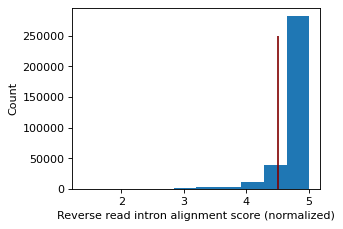

In [16]:
#I want to get an idea of what a typical score is for aligning the portion of a reverse read following the interaction
#sequence to the WT intron. This cell performs each alignment and produces a histogram of the resulting scores. 
#Because a shoter sequence with a perfect alignment will always have a lower score than a longer sequence with a 
#perfect alignment, it is important to normalize here, unlike in previous alignments, becuase not all the sequences 
#are the same length. 

#This cell will also print out alignments with scores above and/or below a certain threshold score if you uncomment 
#the commented lines. This is useful if you want to get an idea of what an alignment with a given score actually 
#looks like. If you do so, I recommend running this code on a subset of a subset of the dataframe, rather than 
#the whole thing, to save on time

ribo_score = []
ribo_score_norm = []
count = 0
for i in cat_data_6.iloc[:,9]:
    ribo_score += [aligner.score(ribo_rev,i)]
    ribo_score_norm += [ribo_score[-1]/len(i)]
    if count < 10:     # A maximum of 10 alignments will be printed. Change 10 to a different number if you want to see more/fewer alignments
            if (4.5 < ribo_score_norm[-1]<5): #print alignments with a given score, or in a given range
                alignment = aligner.align(ribo_rev,i)
                print(alignment[0])
                print(ribo_score_norm[-1])
                count += 1
#cat_data_5['Reverse Read ribozyme alignment score']=ribo_score
cat_data_6['Reverse Read ribozyme alignment normalized score']=ribo_score_norm
plt.figure(figsize=(4, 3), dpi=80)
plt.hist(ribo_score_norm)
plt.xlabel('Reverse read intron alignment score (normalized)')
plt.ylabel('Count')
plt.vlines(4.5,0,250000, color = 'maroon')
cat_data_6.to_csv('10_cat_data_ribo_score.csv')
cat_data_6
#As you can see, the vast majority of normalized scores are >4. I have chosen to set a threshold normlazied score of 
#4.0, because a 9 nt sequence with a single mismatch has a score of 4, and if a 9 nucleotide read has even a single 
#mismatch, it might not be able to be aligned to a unique place

In [17]:
#Remove reads rows from dataframe containing reverse reads with ribozyme alignment scores ≤ 4.5
cat_data_7 = cat_data_6[(cat_data_6['Reverse Read ribozyme alignment normalized score'] > 4.5)].copy()

print(str(len(cat_data_6)-len(cat_data_7)) + ' reads ('  + str((len(cat_data_6)-len(cat_data_7))/len(cat_data_6)*100) + '%) were insufficient quality to align to the intron, and were removed from the dataset')
cat_data_7.to_csv('11_cat_data_ribo_score_QC1.csv')
cat_data_7

56154 reads (16.605257710618922%) were insufficient quality to align to the intron, and were removed from the dataset


,Read 1 Index,Read 2 Index,Read 1 Direction,Read 2 Direction,Category,Forward_read,Reverse_read,Reverse Read inserted sequence alignment score,Reverse read inserted sequence end position,Reverse read ribozyme sequence,Reverse Read ribozyme alignment normalized score
2,1.0,1.0,Forward,Reverse,1.0,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CAATGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG,5.0
3,2.0,1.0,Reverse,Forward,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,TACAAATTAGTTCCC,5.0
4,2.0,2.0,Reverse,Forward,2.0,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG,5.0
5,2.0,1.0,Reverse,Forward,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG,5.0
6,1.0,2.0,Forward,Reverse,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG,5.0
...,...,...,...,...,...,...,...,...,...,...,...
384681,2.0,1.0,Reverse,Forward,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG,5.0
384682,3.0,2.0,Reverse,Forward,2.5,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,ACGCCGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG,5.0
384683,1.0,2.0,Forward,Reverse,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCGATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1131.0,233,CCTGAGACTTGGTACTG,5.0
384684,3.0,2.0,Reverse,Forward,2.5,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,ACGCCGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG,5.0


In [18]:
# Many pairwise alignments result in multiple alignments with equivalent scores. This isn't a problem, as long as all
# the alignments agree on where the alignment ends. This cell identifies all the reads where the equivalent alignments
# *do not* end at the same point. This has the added benefit of identifying reads that are too short to align to one 
# unique place in the ribozyme
# Similarly, if the the first base pair(s) of the ribozyme part of the read doesn't align the to the ribozyme, it
# becomes very difficult to determine where exactly the split site should be assigned. For example, it is difficult to
# tell whether the last, mismatched nucleotide is just a miscalled base, in which case the split site should be after
# that base, or it's an incorrectly inserted base, in which the split site should be added before that base. I've
# opted to just removed those reads.

ambiguous_reads = []
bad_end_reads = []
for i in range(len(cat_data_7)):
    alignment = aligner.align(ribo_rev, cat_data_7.iloc[i,9])
    al_start = []
    al_first = []
    for jj in alignment:
        al_indices = jj.aligned
        al_start += [al_indices[0][0][0]]     #The position where the ribozyme read aligns to the ribozyme sequence
        al_first += [al_indices[1][0][0]]     #The number of the first nucleotide in the read that aligns to the ribozyme (this should be zero!)
    if not(all(x == al_start[0] for x in al_start)):
        ambiguous_reads += [cat_data_7.index[i]]      # A list of the indices of all the reads that don't align to exactly one site in the ribozyme 
    if any(x != 0 for x in al_first):
        bad_end_reads += [cat_data_7.index[i]]
#Remove rows of the dataframe corresponding to reads  where the equivalent alignments
# *do not* end at the same point.

cat_data_8 = cat_data_7.loc[~cat_data_7.index.isin(ambiguous_reads + bad_end_reads)].copy()
print(str(len(cat_data_7)-len(cat_data_8)) + ' reads (' + str((len(cat_data_7)-len(cat_data_8))/len(cat_data)*100) + '%) had ambigous alignment ends, and were removed from the dataset')
cat_data_8.to_csv('12_cat_data_ribo_score_QC2.csv')
cat_data_8

3062 reads (0.795973859199451%) had ambigous alignment ends, and were removed from the dataset


,Read 1 Index,Read 2 Index,Read 1 Direction,Read 2 Direction,Category,Forward_read,Reverse_read,Reverse Read inserted sequence alignment score,Reverse read inserted sequence end position,Reverse read ribozyme sequence,Reverse Read ribozyme alignment normalized score
2,1.0,1.0,Forward,Reverse,1.0,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CAATGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG,5.0
3,2.0,1.0,Reverse,Forward,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,TACAAATTAGTTCCC,5.0
4,2.0,2.0,Reverse,Forward,2.0,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG,5.0
5,2.0,1.0,Reverse,Forward,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG,5.0
6,1.0,2.0,Forward,Reverse,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG,5.0
...,...,...,...,...,...,...,...,...,...,...,...
384681,2.0,1.0,Reverse,Forward,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG,5.0
384682,3.0,2.0,Reverse,Forward,2.5,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,ACGCCGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG,5.0
384683,1.0,2.0,Forward,Reverse,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCGATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1131.0,233,CCTGAGACTTGGTACTG,5.0
384684,3.0,2.0,Reverse,Forward,2.5,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,ACGCCGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG,5.0


In [19]:
#The minimum length for which all subsequences of the ribozyme of the that length are unique is 9. That is,
#chunks of the ribozyme less than 9 nucleotides long are not necessarily unique, and may align perfectly to two
#separate sites in the ribozyme. Consequently, any reads for which the sequence following the interaction sequence, 
#correspoing to the ribozyme sequence just prior to the split site, less than nine nucleotides long must be removed
#because the split site cannot be determined unequivocally.

#This function was used to determine the smallest n such that all substrings of length n for a given string are unique
#in that string. The output is 9 for ribozyme
def min_unique_length(input_seq):
    min_length = 1
    count = 2
    while count > 1:
        for i in range(len(input_seq)):
            if i+min_length <= len(input_seq):
                count = input_seq.count(input_seq[i:i+min_length])
            if count > 1:
                min_length += 1
                break
    return min_length

In [20]:
#Remove any entries from the dataframe where the sequence after the interaction sequence is less than the minimum 
#unique sequence length
min_ribo = min_unique_length(ribo_rev)

cat_data_9 = cat_data_8[(cat_data_8['Reverse read ribozyme sequence'].str.len() >= min_ribo)].copy()
print(str(len(cat_data_8)-len(cat_data_9)) + ' reads (' + str(((len(cat_data_8)-len(cat_data_9))/len(cat_data))*100) + '%) were too short to determine insertion site, and were removed from the dataset')
cat_data_9.to_csv('13_cat_data_ribo_score_QC3.csv')
cat_data_9

9 reads (0.002339570454864487%) were too short to determine insertion site, and were removed from the dataset


,Read 1 Index,Read 2 Index,Read 1 Direction,Read 2 Direction,Category,Forward_read,Reverse_read,Reverse Read inserted sequence alignment score,Reverse read inserted sequence end position,Reverse read ribozyme sequence,Reverse Read ribozyme alignment normalized score
2,1.0,1.0,Forward,Reverse,1.0,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CAATGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG,5.0
3,2.0,1.0,Reverse,Forward,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,TACAAATTAGTTCCC,5.0
4,2.0,2.0,Reverse,Forward,2.0,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG,5.0
5,2.0,1.0,Reverse,Forward,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG,5.0
6,1.0,2.0,Forward,Reverse,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG,5.0
...,...,...,...,...,...,...,...,...,...,...,...
384681,2.0,1.0,Reverse,Forward,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG,5.0
384682,3.0,2.0,Reverse,Forward,2.5,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,ACGCCGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG,5.0
384683,1.0,2.0,Forward,Reverse,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCGATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1131.0,233,CCTGAGACTTGGTACTG,5.0
384684,3.0,2.0,Reverse,Forward,2.5,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,ACGCCGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG,5.0


In [21]:
# This cell aligns the part of each reverse read after the interaction sequence to the intron. It then determines 
#where in the intron the reverse read starts, and therefore where the ribozyme was split.
split_site=[]
for i in cat_data_9.iloc[:,9]:
    alignment = aligner.align(ribo_rev, i)
    al_indices = alignment[0].aligned
    split_site += [len(ribo_rev) - al_indices[0][0][0]-14]

#Add list of split sites to dataframe
cat_data_9['Split Site'] = split_site
cat_data_9

,Read 1 Index,Read 2 Index,Read 1 Direction,Read 2 Direction,Category,Forward_read,Reverse_read,Reverse Read inserted sequence alignment score,Reverse read inserted sequence end position,Reverse read ribozyme sequence,Reverse Read ribozyme alignment normalized score,Split Site
2,1.0,1.0,Forward,Reverse,1.0,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CAATGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG,5.0,153
3,2.0,1.0,Reverse,Forward,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,TACAAATTAGTTCCC,5.0,385
4,2.0,2.0,Reverse,Forward,2.0,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG,5.0,153
5,2.0,1.0,Reverse,Forward,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG,5.0,153
6,1.0,2.0,Forward,Reverse,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG,5.0,153
...,...,...,...,...,...,...,...,...,...,...,...,...
384681,2.0,1.0,Reverse,Forward,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG,5.0,153
384682,3.0,2.0,Reverse,Forward,2.5,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,ACGCCGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG,5.0,153
384683,1.0,2.0,Forward,Reverse,1.5,ATACCACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,CTGTGGCTTCGATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1131.0,233,CCTGAGACTTGGTACTG,5.0,153
384684,3.0,2.0,Reverse,Forward,2.5,TTCTTACTTGTCACTACTCTGACCTAAATAGCAATATTTACCTTTG...,ACGCCGCTTCAATAATATTGAAAAAGGAAGAGTAAAAAAAAGCCCG...,1140.0,233,CCTGAGACTTGGTACTG,5.0,153


In [22]:
#Save results so far as a csv so you don't have to redo all your work
cat_data_9.to_csv('Category_All_Processed_Reads.csv')

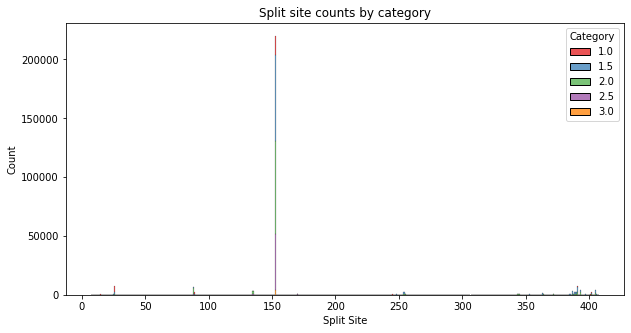

In [23]:
# Create a histogram of the raw number of counts of each split site. This isn't very useful because there are
# different numbers of each categories in the raw reads, so we'll need to convert the raw counts to frequencies at a
# later step.

fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(ax=ax, data=cat_data_9, x="Split Site", hue="Category", multiple="stack", discrete = 'true', palette = 'Set1')
plt.title('Split site counts by category')
plt.savefig('raw_category_split_site_distribution.png', dpi = 300)

In [24]:
#This cell creates a simple dataframe for each category. The first column of each df contains each split site idenfied
#in that category. The second column contains the total number of times that split site was found in that category.
#The third column contains a frequency for the split site, that is, the number in the second column divided by the
#total number of reads in that category (the third column therefore sums to 1)

#Separate all reads based on category

cat_1 = cat_data_9[(cat_data_9['Category'] == 1 )].copy()
cat_15 = cat_data_9[(cat_data_9['Category'] == 1.5 )].copy()
cat_2 = cat_data_9[(cat_data_9['Category'] == 2 )].copy()
cat_25 = cat_data_9[(cat_data_9['Category'] == 2.5 )].copy()
cat_3 = cat_data_9[(cat_data_9['Category'] == 3 )].copy()

site_counts1 = cat_1.groupby(by=["Split Site"]).count()
site_counts1 = site_counts1.iloc[:,0]
site_counts1 = site_counts1.reset_index()
site_counts1.columns = ["Split Site", "Raw Count Cat 1"]
site_counts1['Normalized Count Cat 1'] = site_counts1['Raw Count Cat 1'] / len(cat_1)

site_counts15 = cat_15.groupby(by=["Split Site"]).count()
site_counts15 = site_counts15.iloc[:,0]
site_counts15 = site_counts15.reset_index()
site_counts15.columns = ["Split Site", "Raw Count Cat 1.5"]
site_counts15['Normalized Count Cat 1.5'] = site_counts15['Raw Count Cat 1.5'] / len(cat_15)

site_counts2 = cat_2.groupby(by=["Split Site"]).count()
site_counts2 = site_counts2.iloc[:,0]
site_counts2 = site_counts2.reset_index()
site_counts2.columns = ["Split Site", "Raw Count Cat 2"]
site_counts2['Normalized Count Cat 2'] = site_counts2['Raw Count Cat 2'] / len(cat_2)

site_counts25 = cat_25.groupby(by=["Split Site"]).count()
site_counts25 = site_counts25.iloc[:,0]
site_counts25 = site_counts25.reset_index()
site_counts25.columns = ["Split Site", "Raw Count Cat 2.5"]
site_counts25['Normalized Count Cat 2.5'] = site_counts25['Raw Count Cat 2.5'] / len(cat_25)

site_counts3 = cat_3.groupby(by=["Split Site"]).count()
site_counts3 = site_counts3.iloc[:,0]
site_counts3 = site_counts3.reset_index()
site_counts3.columns = ["Split Site", "Raw Count Cat 3"]
site_counts3['Normalized Count Cat 3'] = site_counts3['Raw Count Cat 3'] / len(cat_3)

#Now we need to recombine each separate catagory dataframe into a single dataframe again. This will make it easier
#to plot.

#First we need to initialize a dataframe that just has every possible split site set to zero
zeroes = pd.DataFrame([0]*(len(ribo_rev)-13), columns = ['init'])

#Next, we need to make the index of each of the separated category dataframes become the split site
site_counts1 = site_counts1.set_index('Split Site')
site_counts1.index.name = None #The above line gives the index column a name, which we don't want

site_counts15 = site_counts15.set_index('Split Site')
site_counts15.index.name = None

site_counts2 = site_counts2.set_index('Split Site')
site_counts2.index.name = None

site_counts25 = site_counts25.set_index('Split Site')
site_counts25.index.name = None

site_counts3 = site_counts3.set_index('Split Site')
site_counts3.index.name = None

#Finally, recombine each normalized split site count
site_counts = pd.concat([zeroes, site_counts1, site_counts15, site_counts2, site_counts25, site_counts3], axis=1)
site_counts = site_counts.fillna(0)
site_counts = site_counts.drop(['init'], axis=1) #Don't need the initialized column anymore
site_counts.reset_index(inplace=True) #need to make the index into a column (indicates split site)

#Prints the whole site_counts dataframe. Most of the split sites don't have any reads, so it looks like a 
#lot of zeros
print(site_counts)

#This displays split sites with at least one read in category 1 or 1.5. Add more categories if you want to see
#others
site_counts[((site_counts['Raw Count Cat 1'] >0) | (site_counts['Raw Count Cat 1.5'] >0) )]
site_counts.to_csv('Category_Site_Counts.csv')

     index  Raw Count Cat 1  Normalized Count Cat 1  Raw Count Cat 1.5  \
0        0              0.0                     0.0                0.0   
1        1              0.0                     0.0                0.0   
2        2              0.0                     0.0                0.0   
3        3              0.0                     0.0                0.0   
4        4              0.0                     0.0                0.0   
..     ...              ...                     ...                ...   
415    415              0.0                     0.0                0.0   
416    416              0.0                     0.0                0.0   
417    417              0.0                     0.0                0.0   
418    418              0.0                     0.0                0.0   
419    419              0.0                     0.0                0.0   

     Normalized Count Cat 1.5  Raw Count Cat 2  Normalized Count Cat 2  \
0                         0.0        

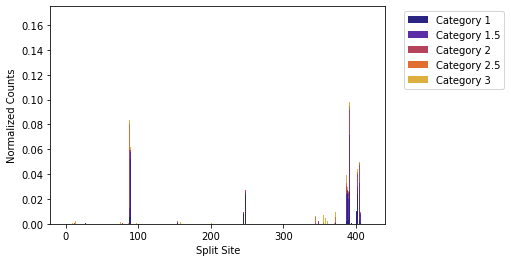

In [25]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = [15, 3.50]
ax.bar(site_counts['index'], site_counts['Normalized Count Cat 1'], 0.75, 
       color = '#2a2582',
       label = 'Category 1')
ax.bar(site_counts['index'], site_counts['Normalized Count Cat 1.5'], 0.75, 
       bottom = site_counts['Normalized Count Cat 1'], 
       color = '#5c2da7',
       label = 'Category 1.5')
ax.bar(site_counts['index'], site_counts['Normalized Count Cat 2'], 0.75, 
       bottom = (site_counts['Normalized Count Cat 1.5']+site_counts['Normalized Count Cat 1']), 
       color = '#b5435b',
       label = 'Category 2')
ax.bar(site_counts['index'], site_counts['Normalized Count Cat 2.5'], 0.75, 
       bottom = (site_counts['Normalized Count Cat 2']+site_counts['Normalized Count Cat 1.5']+site_counts['Normalized Count Cat 1']), 
       color = "#df6e30",
       label = 'Category 2.5')
ax.bar(site_counts['index'], site_counts['Normalized Count Cat 3'], 0.75,
       bottom = (site_counts['Normalized Count Cat 2.5']+site_counts['Normalized Count Cat 2']+site_counts['Normalized Count Cat 1.5']+site_counts['Normalized Count Cat 1']), 
       color = "#ddaf3f",
       label = 'Category 3')

ax.set_ylabel('Normalized Counts')
ax.set_xlabel('Split Site')
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.savefig("Normalized_Split_site_distributions.png", dpi = 300, bbox_inches="tight")
plt.ylim([0, 0.175]) #Uncomment this to shorten y axis to see less frquent insertion sites
plt.savefig("Normalized_Split_site_distributions_crop.png", dpi = 300, bbox_inches="tight")
plt.show()


/Users/laurengambill/opt/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


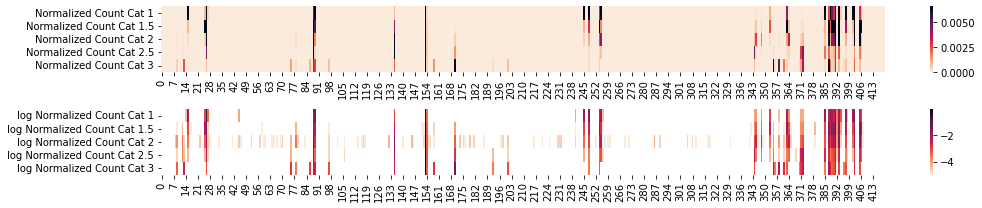

In [26]:
site_counts['log Normalized Count Cat 1'] = np.log10(site_counts['Normalized Count Cat 1'])
site_counts['log Normalized Count Cat 1.5'] = np.log10(site_counts['Normalized Count Cat 1.5'])
site_counts['log Normalized Count Cat 2'] = np.log10(site_counts['Normalized Count Cat 2'])
site_counts['log Normalized Count Cat 2.5'] = np.log10(site_counts['Normalized Count Cat 2.5'])
site_counts['log Normalized Count Cat 3'] = np.log10(site_counts['Normalized Count Cat 3'])
site_counts.replace(-np.inf,np.nan, inplace=True)

fig, axes = plt.subplots(2, figsize = [15,3])
sns.heatmap(site_counts.transpose().iloc[11:16,:], 
            cmap = "rocket_r", 
            ax=axes[1], 
            #square = True #forces heapmat grid to be squre
           )

sns.heatmap(site_counts.transpose().iloc[[2,4,6,8,10],:], 
            cmap = "rocket_r", ax=axes[0], 
            robust = True, 
            #square = True #forces heapmat grid to be squre
           )

fig.tight_layout()
plt.savefig('categories_heatmap.png', dpi = 300)


In [27]:
# Here we want to do some analyses on just the best performing variants, which I will be defining as categories 
# 1, 1.5, and 2. This cell isolates the data for just those catgories, and adss a new coloumn that is the total
# of the number of counts for each of these categories for a given split site

site_counts_12=site_counts.iloc[:,[0,1,2,3,4,5,6,11,12,13]].copy()
site_counts_12['Total Count'] = site_counts_12['Raw Count Cat 1'] + site_counts_12['Raw Count Cat 1.5'] + site_counts_12['Raw Count Cat 2']
site_counts_12[(site_counts_12['Total Count'] >0)]


,index,Raw Count Cat 1,Normalized Count Cat 1,Raw Count Cat 1.5,Normalized Count Cat 1.5,Raw Count Cat 2,Normalized Count Cat 2,log Normalized Count Cat 1,log Normalized Count Cat 1.5,log Normalized Count Cat 2,Total Count
8,8,0.0,0.000000,0.0,0.000000,3.0,0.000031,NaN,NaN,-4.509547,3.0
9,9,0.0,0.000000,1.0,0.000010,12.0,0.000124,NaN,-4.994256,-3.907487,13.0
12,12,0.0,0.000000,4.0,0.000041,25.0,0.000258,NaN,-4.392196,-3.588729,29.0
13,13,0.0,0.000000,0.0,0.000000,2.0,0.000021,NaN,NaN,-4.685639,2.0
14,14,1.0,0.000036,0.0,0.000000,0.0,0.000000,-4.440263,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...
401,401,260.0,0.009434,88.0,0.000892,32.0,0.000330,-2.025290,-3.049773,-3.481519,380.0
402,402,653.0,0.023695,685.0,0.006941,949.0,0.009786,-1.625350,-2.158565,-2.009403,2287.0
405,405,84.0,0.003048,2903.0,0.029417,1414.0,0.014581,-2.515984,-1.531409,-1.836219,4401.0
406,406,25.0,0.000907,715.0,0.007245,79.0,0.000815,-3.042323,-2.139950,-3.089042,819.0


In [38]:
# Next, we are going to add a binary column that just states whether the split site was present at least once in the
# data for categories 1-2

site_counts_12['Present'] = site_counts_12['Total Count']/site_counts_12['Total Count']
site_counts_12['Present'] = site_counts_12['Present'].fillna(0)
site_counts_12.iloc[20:30,:]
site_counts_12.to_csv('Category_Site_Counts_combinedcat_binary.csv')

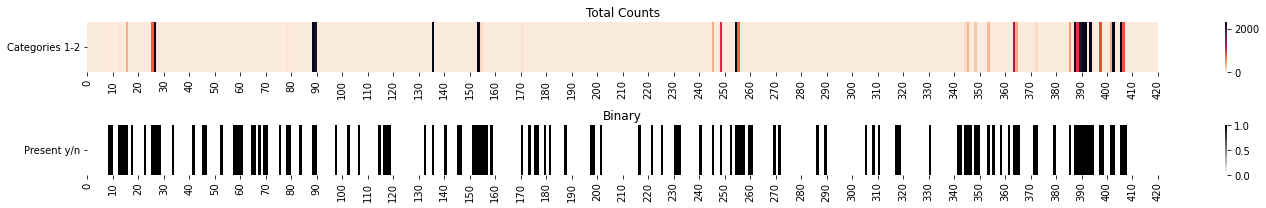

In [37]:
#Plot heatmaps for the total counts for the combined categories 1-2 and a binary heatmap
fig, axes = plt.subplots(2, figsize = [20,3])

x=site_counts_12.transpose().iloc[[10],:]
mask = x.isnull()
sns.heatmap(x, 
            ax=axes[0], 
            cmap = "rocket_r", 
            robust = True,
            yticklabels = ['Categories 1-2'],
            mask=mask
            #xticklabels = [] #removes x axis labels
            #square = True #forces heapmat grid to be squre
           )
axes[0].set_title('Total Counts')
axes[0].tick_params(axis='y', labelrotation = 0)
sns.heatmap(site_counts_12.transpose().loc[['Present'],:],
            ax = axes[1],
            #robust = True,
            cmap = "gray_r", 
            yticklabels = ['Present y/n']
            #square = True #forces heapmat grid to be squre
           )
axes[1].set_title('Binary')
axes[1].tick_params(axis='y', labelrotation = 0)
axes[0].xaxis.set_major_locator(ticker.MultipleLocator(10)) #change the number here to set the x tick label 
axes[0].xaxis.set_major_formatter(ticker.ScalarFormatter())
axes[1].xaxis.set_major_locator(ticker.MultipleLocator(10)) #change the number here to set the x tick label 
axes[1].xaxis.set_major_formatter(ticker.ScalarFormatter())
# axes[0].set_xlim(left = 161, right = 175) #Adjust these to zoom in on a specific portion of the plot
# axes[1].set_xlim(left = 161, right = 175)
fig.tight_layout()
plt.savefig(r'cat12.png', dpi = 300)


In [30]:
NGS_site_counts = pd.read_csv('Fold_Enrichment_analysis.csv')
fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(ax = ax, x = NGS_site_counts['index'], y = NGS_site_counts['Log2 Fold Change'], color = 'black')
ax.xaxis.set_major_locator(ticker.MultipleLocator(10)) #change the number here to set the x tick label 
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
#plt.ylim(np.nanmin(site_counts['Log Fold Change'][site_counts['Log Fold Change'] != -np.inf])) #Set lower y axis limit to be the lowest value that's not -inf or Nan
plt.hlines(np.nanmin(NGS_site_counts['Log2 Fold Change'][NGS_site_counts['Log2 Fold Change'] != -np.inf])+0.5,
          0, len(site_counts))
plt.xlabel('Split Site')
#plt.vlines([26, 153, 252, 327, 347,402], 0,3, alpha = 0.2)
#plt.vlines([369], 0,-4, alpha = 0.2)
#plt.vlines([30,90,233,410], 3,-4,alpha = 0.2, color='r')
plt.xlim(0,420)
plt.savefig(r'test.png', dpi = 300)
#plt.xlim(360,370)
#plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'Fold_Enrichment_analysis.csv'